In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

## Data Description

    Date:    The date this data pertains to.
    Open:    The opening price for the asset on the given date.
    High:    The high price for the asset on the given date.
    Low:     Low proce for theasset on the given date
    close:   closing proce for the asset on given date.
    Volume:  The number of shares traded on IEX only.

In [2]:
# getting data from tiingo webesite using API 
'''
ticker name= stock name in tiingo website
Start Date= Date from when we need historical data of a stock(format YYYY-MM-DD)
resampleFreq = This allows you to set the frequency in which you want data resampled. For example "1hour" would return the data where OHLC is calculated on an hourly schedule.

'''
def data_extraction(ticker_name,startDate,resampleFreq,token):
    url="https://api.tiingo.com/iex/{}/prices?startDate={}&resampleFreq={}&columns=open,high,low,close,volume&token={}".format(ticker_name,startDate,resampleFreq,token)

    data=requests.get(url)
    dataset=data.json()
    #print(data.status_code)
    return dataset
    
json_dataset=data_extraction(ticker_name='aapl',startDate='2019-01-02',resampleFreq='1hour',token='a159a3a83b1754845d7353fbec1c9f2902d4a8e1')

In [3]:
stock_df=pd.json_normalize(json_dataset)
stock_df

,date,open,high,low,close,volume
0,2019-01-02T15:00:00.000Z,155.140,157.190,154.575,156.850,85705.0
1,2019-01-02T16:00:00.000Z,156.850,158.340,156.740,157.065,71070.0
2,2019-01-02T17:00:00.000Z,157.065,158.395,156.925,158.160,45895.0
3,2019-01-02T18:00:00.000Z,158.170,158.820,158.135,158.725,44166.0
4,2019-01-02T19:00:00.000Z,158.730,158.735,157.770,157.910,71703.0
...,...,...,...,...,...,...
8240,2023-07-07T15:00:00.000Z,190.675,191.810,190.655,191.765,98422.0
8241,2023-07-07T16:00:00.000Z,191.765,192.520,191.765,192.315,133554.0
8242,2023-07-07T17:00:00.000Z,192.310,192.685,192.145,192.320,67629.0
8243,2023-07-07T18:00:00.000Z,192.320,192.510,192.165,192.260,34773.0


## checking NULL values

In [4]:
NULL_check=stock_df.isnull().sum()

if (NULL_check.values>0).any():
    print("Null values present")

else:
    print("No null values")


No null values


#### Observation:  
    NO null values 

## Checking data types

In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8245 entries, 0 to 8244
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8245 non-null   object 
 1   open    8245 non-null   float64
 2   high    8245 non-null   float64
 3   low     8245 non-null   float64
 4   close   8245 non-null   float64
 5   volume  8245 non-null   float64
dtypes: float64(5), object(1)
memory usage: 386.6+ KB


In [6]:
## converting date column into datetime format

stock_df['date']=pd.to_datetime(stock_df['date'])

## Checking data from period to period

In [7]:
stock_df.head(),stock_df.tail()

(                       date     open     high      low    close   volume
 0 2019-01-02 15:00:00+00:00  155.140  157.190  154.575  156.850  85705.0
 1 2019-01-02 16:00:00+00:00  156.850  158.340  156.740  157.065  71070.0
 2 2019-01-02 17:00:00+00:00  157.065  158.395  156.925  158.160  45895.0
 3 2019-01-02 18:00:00+00:00  158.170  158.820  158.135  158.725  44166.0
 4 2019-01-02 19:00:00+00:00  158.730  158.735  157.770  157.910  71703.0,
                           date     open     high      low    close    volume
 8240 2023-07-07 15:00:00+00:00  190.675  191.810  190.655  191.765   98422.0
 8241 2023-07-07 16:00:00+00:00  191.765  192.520  191.765  192.315  133554.0
 8242 2023-07-07 17:00:00+00:00  192.310  192.685  192.145  192.320   67629.0
 8243 2023-07-07 18:00:00+00:00  192.320  192.510  192.165  192.260   34773.0
 8244 2023-07-07 19:00:00+00:00  192.260  192.395  190.585  190.695  181536.0)

### Observation
    data is 
    starting--------------'2019-01-02'(yyy-mm-dd)
    till------------------'2023-07-0'

In [8]:
# using close column to predict the stock
close_stock=stock_df['close']

In [9]:
close_stock.tail()

8240    191.765
8241    192.315
8242    192.320
8243    192.260
8244    190.695
Name: close, dtype: float64

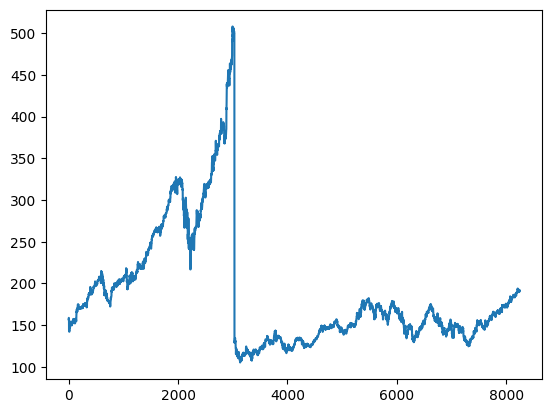

In [10]:
plt.plot(close_stock)

## Data Scaling 

        LSTM are sensitive to the scale of data. So we apply MinMax scaler

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
close_stock=scaler.fit_transform(np.array(close_stock).reshape(-1,1))

In [21]:
close_stock

array([[0.12811666],
       [0.12865033],
       [0.13136829],
       ...,
       [0.21615886],
       [0.21600993],
       [0.21212535]])

## Train Test split

    >since the problem here is time series we dont use cross validation or random seed for train test split
    >the data is depend on previous data for any time series
        ex:- Day1  Day2  Day3
              120  130    145
              
              here day2 value depend on day1 stock close value

In [22]:
#Splitting train and test data

training_size=int(len(close_stock)*0.65) #65% train data
test_size=len(close_stock)-training_size  # 35% test size

In [23]:
training_size,test_size

(5359, 2886)

In [24]:
# we prepare train and test data by using above training_size and test_size

#since trainnig size is 5339 train data will be till 0 to 5350
train_data,test_data=close_stock[0:training_size],close_stock[training_size:len(close_stock),:1]

In [25]:
len(train_data),len(test_data)

(5359, 2886)

In [42]:
previous_days=150
restofdays=len(test_data)-previous_days
restofdays

#test_data[restofdays:]

x_input=test_data[restofdays:].reshape(1,-1)
x_input.shape

_input=list(x_input)
_input=_input[0].tolist()
_input

#test_data[2736:]

[0.18441203847347193,
 0.18540490226497058,
 0.1869934843313683,
 0.1869934843313683,
 0.1890288551039404,
 0.18777536456717342,
 0.1890288551039404,
 0.1905926155755508,
 0.1906174371703382,
 0.18814768848898544,
 0.18814768848898544,
 0.1899844865032579,
 0.19136208501396218,
 0.19152342538008071,
 0.19237977040024823,
 0.19327334781259697,
 0.1950977350294757,
 0.1950977350294757,
 0.19290102389078495,
 0.19329816940738448,
 0.19416692522494572,
 0.19306236425690348,
 0.19282655910642255,
 0.19379460130313375,
 0.19379460130313375,
 0.1949612162581446,
 0.19573068569655605,
 0.19576791808873717,
 0.19478746509463235,
 0.19443996276760783,
 0.19533354017995658,
 0.19533354017995658,
 0.19905677939807637,
 0.19932981694073842,
 0.19826248836487748,
 0.199677319267763,
 0.2013279553211294,
 0.20048402109835556,
 0.20048402109835556,
 0.19980142724170025,
 0.19990071362085016,
 0.20029785913744963,
 0.19941669252249455,
 0.1977412348743407,
 0.19803909401179032,
 0.19803909401179032,
 0

## Data Preprocessing

In [37]:
# conveting an array of values into dataset matrix

def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [38]:
#reshaping 
time_step=150
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [39]:
print(X_train.shape)
print(X_test.shape)

(5208, 150)
(2735, 150)


# Creating Stacked LSTM model

 we should remember that before implementing the lstm model we should reshape our X_train and X_test to 3 dimensionals

In [33]:
#reshaping input to be[samples,time steps,features]
##X_train.shape[0],X_train.shape[1],1--(5253, 100, 1) 1 is nothing but time step

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [44]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))# first layer we pass "X_train.shape[1],1"
model.add(LSTM(50,return_sequences=True))# second layer
model.add(LSTM(50))#third layer
model.add(Dense(1))#output layer

model.compile(loss="mean_squared_error",optimizer='adam')

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_5 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
83/83 [==============================] - 44s 459ms/step - loss: 0.0089 - val_loss: 8.1399e-05
Epoch 2/100
83/83 [==============================] - 32s 391ms/step - loss: 0.0014 - val_loss: 9.4555e-05
Epoch 3/100
83/83 [==============================] - 46s 561ms/step - loss: 0.0013 - val_loss: 8.4580e-05
Epoch 4/100
83/83 [==============================] - 28s 340ms/step - loss: 0.0011 - val_loss: 1.1021e-04
Epoch 5/100
83/83 [==============================] - 32s 384ms/step - loss: 8.3067e-04 - val_loss: 1.1563e-04
Epoch 6/100
83/83 [==============================] - 36s 442ms/step - loss: 7.0139e-04 - val_loss: 8.1161e-05
Epoch 7/100
83/83 [==============================] - 33s 405ms/step - loss: 6.8058e-04 - val_loss: 3.7395e-05
Epoch 8/100
83/83 [==============================] - 31s 381ms/step - loss: 5.5398e-04 - val_loss: 1.4393e-04
Epoch 9/100
83/83 [==============================] - 29s 356ms/step - loss: 5.5921e-04 - val_loss: 5.2790e-05
Epoch 10/100
83/83 [======

83/83 [==============================] - 33s 402ms/step - loss: 2.4550e-04 - val_loss: 1.5413e-05
Epoch 76/100
83/83 [==============================] - 36s 432ms/step - loss: 2.2695e-04 - val_loss: 1.4815e-05
Epoch 77/100
83/83 [==============================] - 34s 413ms/step - loss: 2.2085e-04 - val_loss: 1.4049e-05
Epoch 78/100
83/83 [==============================] - 58s 699ms/step - loss: 2.0786e-04 - val_loss: 1.2811e-04
Epoch 79/100
83/83 [==============================] - 54s 659ms/step - loss: 2.2160e-04 - val_loss: 1.4472e-05
Epoch 80/100
83/83 [==============================] - 31s 374ms/step - loss: 2.2368e-04 - val_loss: 1.4787e-05
Epoch 81/100
83/83 [==============================] - 33s 394ms/step - loss: 2.1909e-04 - val_loss: 1.4457e-05
Epoch 82/100
83/83 [==============================] - 30s 356ms/step - loss: 2.3224e-04 - val_loss: 1.4134e-05
Epoch 83/100
83/83 [==============================] - 31s 372ms/step - loss: 2.1699e-04 - val_loss: 1.3193e-05
Epoch 84/100
8

In [47]:
# predicitions for test and train data

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

87/87 [==============================] - 9s 103ms/step


In [48]:
# Transforming back to original form for calculating RMSE
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [49]:
# calculating RMSE performance metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

221.64676713851958

In [54]:
##test data RMSE

math.sqrt(mean_squared_error(y_test,test_predict))

157.66836188268024

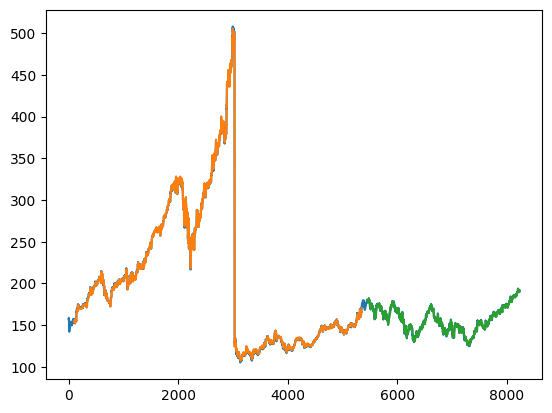

In [57]:
## plotting graph for both test and train data predictions
'''
orange color= train prediction
bule color = full data
green color=test prediction
'''
# shifting train predictions for plotting
look_back=100
trainpredictplot=np.empty_like(close_stock)
trainpredictplot[:,:]=np.nan
trainpredictplot[look_back:len(train_predict)+look_back,:]=train_predict

#shifting test predictions for plotting

testpredictplot=np.empty_like(close_stock)
testpredictplot[:,:]=np.nan
testpredictplot[len(train_predict)+(look_back*2)+1:len(close_stock)-1, :]=test_predict

#plot baseline and predicitons
plt.plot(scaler.inverse_transform(close_stock))
plt.plot(trainpredictplot)
plt.plot(testpredictplot)
plt.show()

In [58]:
len(test_data)

2884

In [66]:
#calculating for 150 days
x_input=test_data[2734:].reshape(1,-1)
x_input.shape

(1, 150)

In [67]:
#converting into list 
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [68]:
temp_input

[0.18011790257524052,
 0.1812224635432827,
 0.18016754576481536,
 0.18016754576481536,
 0.1834067638845796,
 0.1843748060812907,
 0.18462302202916542,
 0.18441203847347193,
 0.18540490226497058,
 0.1869934843313683,
 0.1869934843313683,
 0.1890288551039404,
 0.18777536456717342,
 0.1890288551039404,
 0.1905926155755508,
 0.1906174371703382,
 0.18814768848898544,
 0.18814768848898544,
 0.1899844865032579,
 0.19136208501396218,
 0.19152342538008071,
 0.19237977040024823,
 0.19327334781259697,
 0.1950977350294757,
 0.1950977350294757,
 0.19290102389078495,
 0.19329816940738448,
 0.19416692522494572,
 0.19306236425690348,
 0.19282655910642255,
 0.19379460130313375,
 0.19379460130313375,
 0.1949612162581446,
 0.19573068569655605,
 0.19576791808873717,
 0.19478746509463235,
 0.19443996276760783,
 0.19533354017995658,
 0.19533354017995658,
 0.19905677939807637,
 0.19932981694073842,
 0.19826248836487748,
 0.199677319267763,
 0.2013279553211294,
 0.20048402109835556,
 0.20048402109835556,
 0.1

In [69]:
from numpy import array

lst_output=[]
n_steps=150
i=0
while (i<100):
    #if pevious input is greater than 100 . the whole process will happen util we finish 100 days
    if(len(temp_input)>150):
        #we shift the position
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input) )
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print("{} day output".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape(1,n_steps,1)
        #passing 100 values to model 
        yhat=model.predict(x_input,verbose=0)
        #adding yhat value to previous values i.e temp_input.once we add value it will have 151 value then we shift from one postion and take from next(if condition)
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        #adding yhat value from predict to final output
        lst_output.extend(yhat.tolist())
        i=i+1
            

151
1 day input [0.18122246 0.18016755 0.18016755 0.18340676 0.18437481 0.18462302
 0.18441204 0.1854049  0.18699348 0.18699348 0.18902886 0.18777536
 0.18902886 0.19059262 0.19061744 0.18814769 0.18814769 0.18998449
 0.19136209 0.19152343 0.19237977 0.19327335 0.19509774 0.19509774
 0.19290102 0.19329817 0.19416693 0.19306236 0.19282656 0.1937946
 0.1937946  0.19496122 0.19573069 0.19576792 0.19478747 0.19443996
 0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20

6 day output
7 day input [0.18441204 0.1854049  0.18699348 0.18699348 0.18902886 0.18777536
 0.18902886 0.19059262 0.19061744 0.18814769 0.18814769 0.18998449
 0.19136209 0.19152343 0.19237977 0.19327335 0.19509774 0.19509774
 0.19290102 0.19329817 0.19416693 0.19306236 0.19282656 0.1937946
 0.1937946  0.19496122 0.19573069 0.19576792 0.19478747 0.19443996
 0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.1987

12 day output
13 day input [0.18902886 0.19059262 0.19061744 0.18814769 0.18814769 0.18998449
 0.19136209 0.19152343 0.19237977 0.19327335 0.19509774 0.19509774
 0.19290102 0.19329817 0.19416693 0.19306236 0.19282656 0.1937946
 0.1937946  0.19496122 0.19573069 0.19576792 0.19478747 0.19443996
 0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20

18 day output
19 day input [0.19136209 0.19152343 0.19237977 0.19327335 0.19509774 0.19509774
 0.19290102 0.19329817 0.19416693 0.19306236 0.19282656 0.1937946
 0.1937946  0.19496122 0.19573069 0.19576792 0.19478747 0.19443996
 0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.20

24 day output
25 day input [0.19290102 0.19329817 0.19416693 0.19306236 0.19282656 0.1937946
 0.1937946  0.19496122 0.19573069 0.19576792 0.19478747 0.19443996
 0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20

30 day output
31 day input [0.1937946  0.19496122 0.19573069 0.19576792 0.19478747 0.19443996
 0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.2

36 day output
37 day input [0.19533354 0.19533354 0.19905678 0.19932982 0.19826249 0.19967732
 0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.2

42 day output
43 day input [0.20132796 0.20048402 0.20048402 0.19980143 0.19990071 0.20029786
 0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.2

48 day output
49 day input [0.19941669 0.19774123 0.19803909 0.19803909 0.19803909 0.19803909
 0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.2

54 day output
55 day input [0.19803909 0.19803909 0.19803909 0.19803909 0.19803909 0.19766677
 0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.2

60 day output
61 day input [0.19789016 0.19982625 0.19935464 0.19915607 0.19806392 0.19806392
 0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.2

66 day output
67 day input [0.1942538  0.19367049 0.19610301 0.19697177 0.19775365 0.19538318
 0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.21394974 0.21495501 0.21341842
 0.21320471 0.21270335 0.21213141 0.2

72 day output
73 day input [0.19538318 0.20031027 0.20131554 0.2008067  0.20158858 0.2021843
 0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.21394974 0.21495501 0.21341842
 0.21320471 0.21270335 0.21213141 0.2115418  0.21095368 0.21037745
 0.20981824 0.20927733 0.20875323 0.2

78 day output
79 day input [0.2028793  0.2028793  0.20120385 0.20186162 0.20292895 0.2037977
 0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.21394974 0.21495501 0.21341842
 0.21320471 0.21270335 0.21213141 0.2115418  0.21095368 0.21037745
 0.20981824 0.20927733 0.20875323 0.20824295 0.20774287 0.20724937
 0.20675933 0.20627019 0.20578018 0.

84 day output
85 day input [0.20217189 0.20214707 0.20214707 0.20449271 0.20268073 0.20059572
 0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.21394974 0.21495501 0.21341842
 0.21320471 0.21270335 0.21213141 0.2115418  0.21095368 0.21037745
 0.20981824 0.20927733 0.20875323 0.20824295 0.20774287 0.20724937
 0.20675933 0.20627019 0.20578018 0.20528817 0.20479366 0.20429653
 0.20379716 0.20329589 0.20279327 0

90 day output
91 day input [0.20004964 0.20084393 0.19878374 0.19878374 0.20225877 0.20325163
 0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.21394974 0.21495501 0.21341842
 0.21320471 0.21270335 0.21213141 0.2115418  0.21095368 0.21037745
 0.20981824 0.20927733 0.20875323 0.20824295 0.20774287 0.20724937
 0.20675933 0.20627019 0.20578018 0.20528817 0.20479366 0.20429653
 0.20379716 0.20329589 0.20279327 0.20228991 0.20178631 0.20128286
 0.20077997 0.20027795 0.19977689 0

96 day output
97 day input [0.20457958 0.20575861 0.20549798 0.20553522 0.20553522 0.20824077
 0.20886131 0.20672665 0.20784362 0.2078188  0.20863791 0.20863791
 0.20874961 0.20982935 0.20876202 0.20902265 0.20977971 0.20938256
 0.20938256 0.21668011 0.21623332 0.21705244 0.21807012 0.21787155
 0.22005585 0.22005585 0.21532733 0.21591064 0.21650636 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083 0.21658083
 0.21658083 0.21658083 0.21658083 0.21658083 0.21623332 0.21270866
 0.2132175  0.21272107 0.21362706 0.21371393 0.21371393 0.20923363
 0.21161651 0.21278312 0.21387527 0.21394974 0.21495501 0.21341842
 0.21320471 0.21270335 0.21213141 0.2115418  0.21095368 0.21037745
 0.20981824 0.20927733 0.20875323 0.20824295 0.20774287 0.20724937
 0.20675933 0.20627019 0.20578018 0.20528817 0.20479366 0.20429653
 0.20379716 0.20329589 0.20279327 0.20228991 0.20178631 0.20128286
 0.20077997 0.20027795 0.19977689 0.19927695 0.19877821 0.19828066
 0.1977843  0.19728917 0.19679525 0

In [81]:
day_new=np.arange(1,151)
#since we want to predict for 100 days
day_pred=np.arange(151,251)

In [82]:
len(close_stock)

8238

In [83]:
df=close_stock.tolist()
df.extend(lst_output)

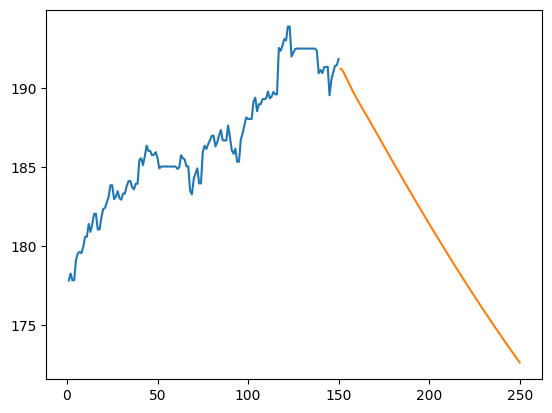

In [84]:
plt.plot(day_new,scaler.inverse_transform(close_stock[8088:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

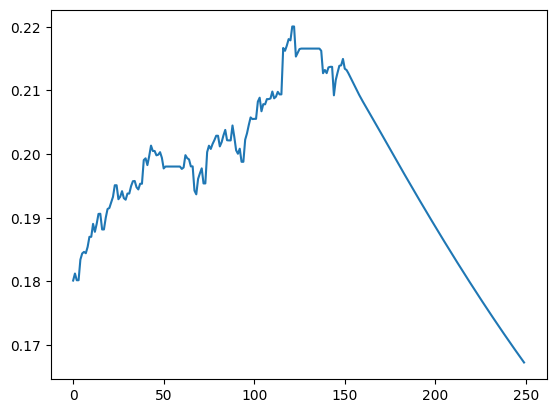

In [91]:
df2=close_stock.tolist()
df2.extend(lst_output)
plt.plot(df[8088:])#8238